# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
from imageio import imread

In [3]:
# Doing the required imports :
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.losses import categorical_crossentropy
#from keras.optimizers import Adam,SGD
from keras.layers.convolutional import Conv2D, MaxPooling3D, Conv3D, MaxPooling2D
from keras.layers.recurrent import GRU
from keras.layers import Activation, Dropout, ZeroPadding3D
from keras.layers.recurrent import LSTM
from tensorflow.keras.optimizers import Adam

In [4]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import datetime
import os
# Importing additional libraries which might be needed for image pre-processing :

#import resize as imresize
#import sckikit-image as skimage
import cv2
import imageio as imio
from PIL import Image

We set the random seed so that the results don't vary drastically.

In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)

import tensorflow as tf
from keras import backend as K

#tf.set_random_seed(30)
import matplotlib.pyplot as plt

# Set the random seed
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [10]:
#train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
#val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())
#experiment with the batch size
batch_size =25

In [11]:
# Print the number of documents read to check
print("Number of documents in train_doc:", len(train_doc))

Number of documents in train_doc: 663


In [12]:
# Print the number of documents read to check
print("Number of documents in train_doc:", len(val_doc))

Number of documents in train_doc: 100


In [6]:
# Custom function to crop image :

def crop_img(img, scale=1.0):
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img_cropped = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    return img_cropped

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [14]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #create a list of image numbers you want to use for a particular video
    #list(range(0,29,2))
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        # calculate the number of batches
        num_batches = int(len(t)/batch_size)
        # we iterate over the number of batches
        for batch in range(num_batches): 
            batch_data = np.zeros((batch_size,18,64,64,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Cropping image by 10 % of original size :
                    image = crop_img(image, 0.10)
                    # Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,0])/255#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,64,64,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    # Cropping image by 10 % of original size :
                    image = crop_img(image, 0.10)

                    # Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)

                    # Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [15]:
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 5 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

# Model 1.
## Conv 3D Model with 5 epochs, 25 batch size
### Without dropouts in Conv layer and with batch normalization:
#### Input image size 64X64
#### adam optimiser 
#### learning rate 0.0002 with decay
#### 18 images as input out of 30

In [17]:
# Building the first model which is 3D Conv model:

modelConv3D_1 = Sequential()

modelConv3D_1.add(Conv3D(8, (3,3,3), padding='same', input_shape=(18,64,64,3)))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_1.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_1.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_1.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_1.add(Flatten())
modelConv3D_1.add(Dense(64, activation='relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Dense(64, activation='relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Dense(5, activation='softmax'))

#write your optimizer
optimiser = tf.keras.optimizers.Adam(lr=0.0002, decay=1e-6)

# compile model :
modelConv3D_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary :
print (modelConv3D_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 64, 64, 8)     656       
                                                                 
 activation (Activation)     (None, 18, 64, 64, 8)     0         
                                                                 
 batch_normalization (BatchN  (None, 18, 64, 64, 8)    32        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 32, 32, 8)     0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 32, 32, 16)     3472      
                                                                 
 activation_1 (Activation)   (None, 9, 32, 32, 16)     0

2024-11-04 18:31:00.138084: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-11-04 18:31:00.138144: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3d:00.0, compute capability: 7.5
/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
print("Total Params in model:", modelConv3D_1.count_params())

Total Params in model: 144421


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [26]:
#Completed this step during model creation only
#optimiser = #write your optimizer
#model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#print (model.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [19]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [20]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [21]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [22]:
# Modified the fit generator to use multiproessing to improve the training time :
# This is for first model 3D Conv model: (modelConv3D_1)
history = modelConv3D_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_202/404589656.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = modelConv3D_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 25
Epoch 1/5


2024-11-04 18:31:33.585952: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


27/27 [==============================] - ETA: 0s - loss: 2.1787 - categorical_accuracy: 0.2172Source path =  /datasets/Project_data/val ; batch size = 25

Epoch 00001: saving model to model_init_2024-11-0418_30_52.131293/model-00001-2.17871-0.21719-1.61952-0.20000.h5
27/27 [==============================] - 27s 911ms/step - loss: 2.1787 - categorical_accuracy: 0.2172 - val_loss: 1.6195 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 2/5
27/27 [==============================] - ETA: 0s - loss: 1.8337 - categorical_accuracy: 0.3198
Epoch 00002: saving model to model_init_2024-11-0418_30_52.131293/model-00002-1.83370-0.31976-1.66034-0.20000.h5
27/27 [==============================] - 24s 913ms/step - loss: 1.8337 - categorical_accuracy: 0.3198 - val_loss: 1.6603 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/5
27/27 [==============================] - ETA: 0s - loss: 1.7857 - categorical_accuracy: 0.3318
Epoch 00003: saving model to model_init_2024-11-0418_30_52.1312

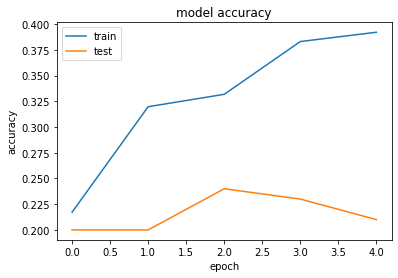

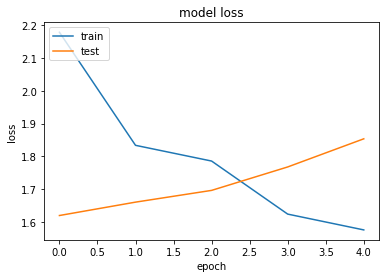

In [23]:
# Plotting the result of Model 1 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### We have got the training accuarcy of 39.22 % and validation accuracy of 21 % in the base model

# Model 2.
## Conv 3D Model with 20 epochs, 30 batch size

Without dropouts in Conv layer and with batch normalization. Input image size 64X64 , adam optimiser with learning rate 0.0002 without decay, 18 images as input out of 30 Changed droput to 0.50 from 0.25 in 1st dense layer

In [24]:
batch_size = 30
num_epochs = 20

In [25]:
# Building the second model which is 3D Conv model:

modelConv3D_2 = Sequential()

modelConv3D_2.add(Conv3D(8, (3,3,3), padding='same', input_shape=(18,64,64,3)))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_2.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_2.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_2.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_2.add(Flatten())
modelConv3D_2.add(Dense(64, activation='relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Dropout(0.50))

modelConv3D_2.add(Dense(64, activation='relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Dropout(0.25))

modelConv3D_2.add(Dense(5, activation='softmax'))

#write your optimizer
optimiser = tf.keras.optimizers.Adam(lr=0.0002)


# compile model :
modelConv3D_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary :
print (modelConv3D_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 64, 64, 8)     656       
                                                                 
 activation_4 (Activation)   (None, 18, 64, 64, 8)     0         
                                                                 
 batch_normalization_6 (Batc  (None, 18, 64, 64, 8)    32        
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 9, 32, 32, 8)     0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 32, 32, 16)     3472      
                                                                 
 activation_5 (Activation)   (None, 9, 32, 32, 16)    

In [26]:
print("Total Params in model:", modelConv3D_2.count_params())

Total Params in model: 144421


In [27]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1 )

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [29]:
# Modified the fit generator to use multiple worker without the multiprocessing training time :

# This is for second model 3D Conv model: )

history = modelConv3D_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,use_multiprocessing=False,
                    workers=1, initial_epoch=0)

/tmp/ipykernel_202/3088767934.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = modelConv3D_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 2.1600 - categorical_accuracy: 0.2383Source path =  /datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2024-11-0418_30_52.131293/model-00001-2.15995-0.23831-1.63600-0.21000.h5
23/23 [==============================] - 23s 1s/step - loss: 2.1600 - categorical_accuracy: 0.2383 - val_loss: 1.6360 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 2.0240 - categorical_accuracy: 0.3077
Epoch 00002: saving model to model_init_2024-11-0418_30_52.131293/model-00002-2.02401-0.30769-1.64620-0.22000.h5
23/23 [==============================] - 22s 1s/step - loss: 2.0240 - categorical_accuracy: 0.3077 - val_loss: 1.6462 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.9265 - categorical_accuracy: 0.3152
Epoch 00003: saving model to model_init_2024-11-0418_30_

In [30]:
print("Total Params in model:", modelConv3D_2.count_params())

Total Params in model: 144421


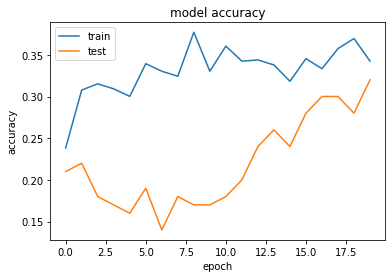

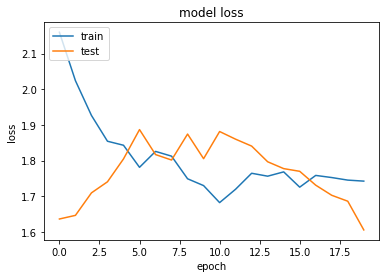

In [31]:
# Plotting the result of Model 2 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

 So we have got accuracy as 34.24% and validation accuracy of 32 % from this model.

# Model 3.
## Conv 3D Model with 20 epochs and 30 batch size
## image size increaed to 84X84
## reduced cropping to 3 % from 10 %

Without dropouts in Conv layer and with batch normalization. adam optimiser with learning rate 0.0002 without decay, 18 images as input out of 30 Reverted back dropout from 0.50 to 0.25 in 1st dense layer

In [32]:
# Modified generator function :

def generator_modified(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,84,84,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes

# Cropping image by 3 % of original size :
                    image = crop_img(image, 0.03)
    
# Resizing the image :    
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                        
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,84,84,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
# Cropping image by 3 % of original size :
                    image = crop_img(image, 0.03)

# Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)

# Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [33]:
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

batch_size = 30
print ('# batch_size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch_size = 30


In [34]:
# Building the  model which is 3D Conv model:

modelConv3D_3 = Sequential()

modelConv3D_3.add(Conv3D(8, (3,3,3), padding='same', input_shape=(18,84,84,3)))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_3.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_3.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_3.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))


modelConv3D_3.add(Flatten())

modelConv3D_3.add(Dense(128, activation='relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Dropout(0.25))

modelConv3D_3.add(Dense(64, activation='relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Dropout(0.25))

modelConv3D_3.add(Dense(5, activation='softmax'))

#write your optimizer
optimiser = tf.keras.optimizers.Adam(lr=0.0002)


# compile model :
modelConv3D_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary :
print (modelConv3D_3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 18, 84, 84, 8)     656       
                                                                 
 activation_8 (Activation)   (None, 18, 84, 84, 8)     0         
                                                                 
 batch_normalization_12 (Bat  (None, 18, 84, 84, 8)    32        
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 9, 42, 42, 8)     0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 9, 42, 42, 16)     3472      
                                                                 
 activation_9 (Activation)   (None, 9, 42, 42, 16)    

In [35]:
print("Total Params in model:", modelConv3D_3.count_params())

Total Params in model: 288101


In [36]:
train_generator = generator_modified(train_path, train_doc, batch_size)
val_generator = generator_modified(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [37]:
history = modelConv3D_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,
                    workers=1, initial_epoch=0)

/tmp/ipykernel_202/1137570482.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = modelConv3D_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 2.1821 - categorical_accuracy: 0.2428Source path =  /datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2024-11-0418_45_15.084458/model-00001-2.18211-0.24284-1.63991-0.18000.h5
23/23 [==============================] - 27s 1s/step - loss: 2.1821 - categorical_accuracy: 0.2428 - val_loss: 1.6399 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.9222 - categorical_accuracy: 0.3032
Epoch 00002: saving model to model_init_2024-11-0418_45_15.084458/model-00002-1.92219-0.30317-1.63102-0.22000.h5
23/23 [==============================] - 26s 1s/step - loss: 1.9222 - categorical_accuracy: 0.3032 - val_loss: 1.6310 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.8046 - categorical_accuracy: 0

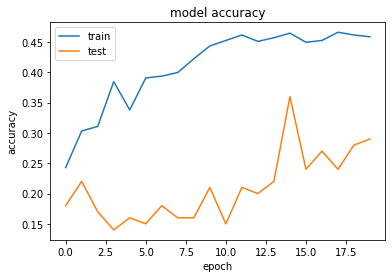

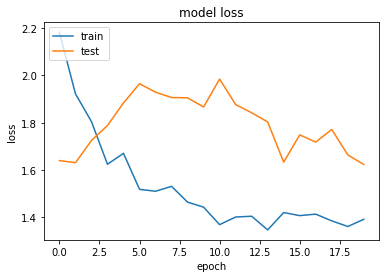

In [38]:
# Plotting the result of Model 3 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### training accuarcy of 45.85 % and validation accuracy of 29 %

# Model 4.
## Conv 3D model
## Increase the image size to 100x100
## batch size 50
## epoch 30

In [7]:
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())

In [8]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,100,100,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes

# Cropping image by 10 % of original size :
                    image = crop_img(image, 0.02)
    
# Resizing the image :    
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                        
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,100,100,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
# Cropping image by 10 % of original size :
                    image = crop_img(image, 0.02)

# Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)

# Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [9]:
modelConv3D_4 = Sequential()

modelConv3D_4.add(Conv3D(8, 
                 kernel_size=(3,3,3), 
                 input_shape=(18,100,100,3),
                 padding='same'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Activation('relu'))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D_4.add(Conv3D(16, 
                 kernel_size=(3,3,3), 
                 padding='same'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Activation('relu'))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D_4.add(Conv3D(32, 
                 kernel_size=(1,3,3), 
                 padding='same'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Activation('relu'))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D_4.add(Conv3D(64, 
                 kernel_size=(1,3,3), 
                 padding='same'))
modelConv3D_4.add(Activation('relu'))
modelConv3D_4.add(Dropout(0.25))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
modelConv3D_4.add(Flatten())

modelConv3D_4.add(Dense(256, activation='relu'))
modelConv3D_4.add(Dropout(0.25))

modelConv3D_4.add(Dense(128, activation='relu'))
modelConv3D_4.add(Dropout(0.25))

#softmax layer
modelConv3D_4.add(Dense(5, activation='softmax'))

2024-11-04 19:33:14.644518: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-11-04 19:33:14.644576: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


In [10]:
optimiser = tf.keras.optimizers.Adam() #write your optimizer
modelConv3D_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelConv3D_4.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 100, 100, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 18, 100, 100, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 100, 100, 8)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 50, 50, 8)     0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 50, 50, 16)     3472      
                                                                 
 batch_normalization_1 (Batc  (None, 9, 50, 50, 16)    6

In [11]:
print("Total Params in model:", modelConv3D_4.count_params())

Total Params in model: 651109


In [12]:
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

batch_size = 50
num_epochs = 30

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

# training sequences = 663
# validation sequences = 100


In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = modelConv3D_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_203/1400168905.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = modelConv3D_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 50
Epoch 1/30


2024-11-04 19:34:13.881966: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


14/14 [==============================] - ETA: 0s - loss: 1.8496 - categorical_accuracy: 0.2127Source path =  /datasets/Project_data/val ; batch size = 50

Epoch 00001: saving model to model_init_2024-11-0419_33_59.975283/model-00001-1.84961-0.21267-1.60643-0.19000.h5
14/14 [==============================] - 29s 2s/step - loss: 1.8496 - categorical_accuracy: 0.2127 - val_loss: 1.6064 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 1.5763 - categorical_accuracy: 0.2519
Epoch 00002: saving model to model_init_2024-11-0419_33_59.975283/model-00002-1.57634-0.25189-1.60560-0.30000.h5
14/14 [==============================] - 27s 2s/step - loss: 1.5763 - categorical_accuracy: 0.2519 - val_loss: 1.6056 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 1.5277 - categorical_accuracy: 0.2971
Epoch 00003: saving model to model_init_2024-11-0419_33_59.975283/model-000

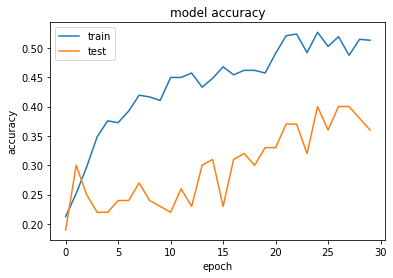

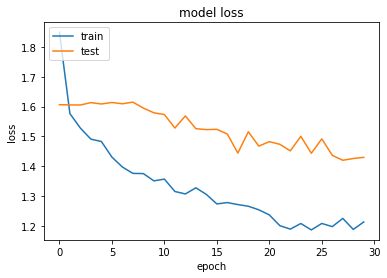

In [15]:
# Plotting the result of Model 4 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Train accuracy 51.28% and  validation accuracy of 36 %.

# Model 5.
## Conv 3D model
## batch size 30
## increased image inputs to 30 
## image size recuced to 84

In [16]:
batch_size = 30

In [17]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0, 30)] 
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,30,84,84,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,30,84,84,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [18]:
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


In [19]:
#write your model here

modelConv3D_5 = Sequential()

modelConv3D_5.add(Conv3D(8, (3,3,3), padding='same', input_shape=(30,84,84,3)))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Flatten())
modelConv3D_5.add(Dense(64, activation='relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Dense(64, activation='relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Dense(5, activation='softmax'))

#write your optimizer
optimiser = tf.keras.optimizers.Adam(lr=0.0002)


# compile model :
modelConv3D_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelConv3D_5.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 84, 84, 8)     656       
                                                                 
 activation_4 (Activation)   (None, 30, 84, 84, 8)     0         
                                                                 
 batch_normalization_3 (Batc  (None, 30, 84, 84, 8)    32        
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 42, 42, 8)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 42, 42, 16)    3472      
                                                                 
 activation_5 (Activation)   (None, 15, 42, 42, 16)   

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
print("Total Params in model:", modelConv3D_5.count_params())

Total Params in model: 181285


In [21]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [22]:
history = modelConv3D_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_203/1110807313.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = modelConv3D_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 2.1389 - categorical_accuracy: 0.2609Source path =  /datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2024-11-0419_49_11.824328/model-00001-2.13887-0.26094-1.59623-0.27000.h5
23/23 [==============================] - 50s 2s/step - loss: 2.1389 - categorical_accuracy: 0.2609 - val_loss: 1.5962 - val_categorical_accuracy: 0.2700 - lr: 2.0000e-04
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.5434 - categorical_accuracy: 0.3967
Epoch 00002: saving model to model_init_2024-11-0419_49_11.824328/model-00002-1.54336-0.39668-1.65241-0.21000.h5
23/23 [==============================] - 49s 2s/step - loss: 1.5434 - categorical_accuracy: 0.3967 - val_loss: 1.6524 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.3809 - categorical_accuracy: 0

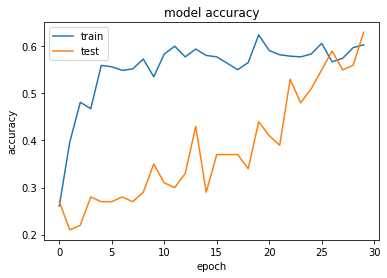

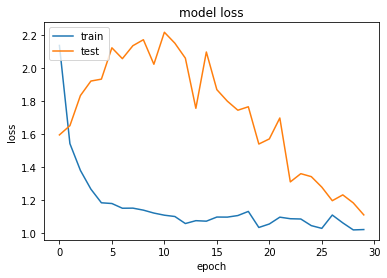

In [23]:
# Plotting the result of Model 5 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### We have achieved the best train accuracy of 60.33 % and validation accuracy of 63 % by the convolutional model.

# Model 6.
## CNN -LSTM Model

In [24]:
# Input
input_shape=(30,120,120,3)

In [25]:
#write your model here
CNNlstm_1 = Sequential()

CNNlstm_1.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=input_shape))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Flatten()))


CNNlstm_1.add(LSTM(128))
CNNlstm_1.add(Dropout(0.25))

CNNlstm_1.add(Dense(128,activation='relu'))
CNNlstm_1.add(Dropout(0.25))

CNNlstm_1.add(Dense(5, activation='softmax'))


#write your optimizer
optimiser = tf.keras.optimizers.Adam()

# compile model :
CNNlstm_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (CNNlstm_1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 60, 60, 32)  

In [26]:
batch_size = 20
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)
print ('# batch_size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch_size = 20


In [27]:
def generatorLSTM(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0, 30)]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,30,120,120,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,30,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [28]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [29]:
history = CNNlstm_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_203/2841256302.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = CNNlstm_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4260 - categorical_accuracy: 0.3695Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-11-0420_14_23.601684/model-00001-1.42604-0.36953-1.74364-0.25000.h5
34/34 [==============================] - 54s 2s/step - loss: 1.4260 - categorical_accuracy: 0.3695 - val_loss: 1.7436 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2223 - categorical_accuracy: 0.5083
Epoch 00002: saving model to model_init_2024-11-0420_14_23.601684/model-00002-1.22226-0.50830-2.13075-0.16000.h5
34/34 [==============================] - 49s 1s/step - loss: 1.2223 - categorical_accuracy: 0.5083 - val_loss: 2.1307 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1099 - categorical_accuracy: 0.5535
Ep

In [30]:
print("Total Params in model:", CNNlstm_1.count_params())

Total Params in model: 1657445


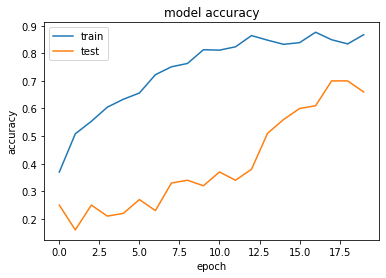

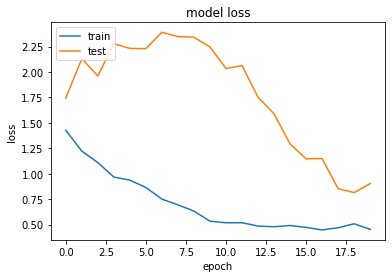

In [31]:
# Plotting the result of Model 6 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Best test accuracy of 86.73% and validation accuracy of 66 % with this model.

# Model 7
## CNN - LSTM Model
## increase input image size to 160x160

In [32]:
# Input
input_shape=(30,160,160,3)


#write your model here
CNNlstm_2 = Sequential()

CNNlstm_2.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=input_shape))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Flatten()))


CNNlstm_2.add(LSTM(128))
CNNlstm_2.add(Dropout(0.25))

CNNlstm_2.add(Dense(128,activation='relu'))
CNNlstm_2.add(Dropout(0.25))

CNNlstm_2.add(Dense(5, activation='softmax'))


#write your optimizer
optimiser = tf.keras.optimizers.Adam()


# compile model :
CNNlstm_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (CNNlstm_2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 30, 160, 160, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 160, 160, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 30, 80, 80, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 80, 80, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 30, 80, 80, 32)  

In [33]:
print("Total Params in model:", CNNlstm_2.count_params())

Total Params in model: 3754597


In [34]:
def generatorLSTM1(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0, 30)]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,30,160,160,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,30,160,160,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [35]:
train_generator = generatorLSTM1(train_path, train_doc, batch_size)
val_generator = generatorLSTM1(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [36]:
history = CNNlstm_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_203/1818313263.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = CNNlstm_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4966 - categorical_accuracy: 0.3756Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-11-0420_14_23.601684/model-00001-1.49658-0.37557-1.83709-0.17000.h5
34/34 [==============================] - 68s 2s/step - loss: 1.4966 - categorical_accuracy: 0.3756 - val_loss: 1.8371 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.3002 - categorical_accuracy: 0.4872
Epoch 00002: saving model to model_init_2024-11-0420_14_23.601684/model-00002-1.30017-0.48718-2.03603-0.21000.h5
34/34 [==============================] - 64s 2s/step - loss: 1.3002 - categorical_accuracy: 0.4872 - val_loss: 2.0360 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1885 - categorical_accuracy: 0.4827
Ep

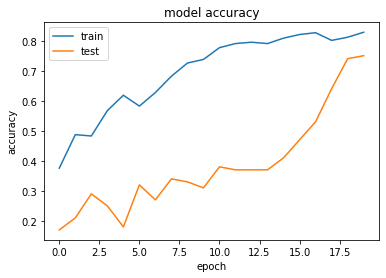

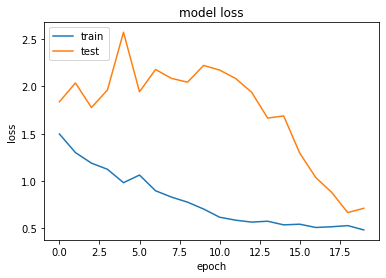

In [37]:
# Plotting the result of Model 7 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Got test accuracy of 82 % and validation accuracy of 75% 

# Model 8
## CNN - LSTM Model
## Increase layers
## increase epoch to 25

In [38]:
input_shape=(30,120,120,3)

CNNlstm_3 = Sequential()
CNNlstm_3.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_3.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_3.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_3.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))


CNNlstm_3.add(Flatten())
CNNlstm_3.add(Dense(64,activation='relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(Dropout(0.25))

CNNlstm_3.add(Dense(64,activation='relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(Dropout(0.25))


CNNlstm_3.add(Dense(5,activation='softmax'))

optimiser = tf.keras.optimizers.Adam()
CNNlstm_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (CNNlstm_3.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_19 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_9 (Conv3D)           (None, 30, 120, 120, 16)  6928      
                                                                 
 activation_9 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_20 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                     

In [39]:
print("Total Params in model:", CNNlstm_3.count_params())

Total Params in model: 1287989


In [40]:
batch_size = 20
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 25
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


In [41]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [42]:
history = CNNlstm_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_203/2700097509.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = CNNlstm_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7906 - categorical_accuracy: 0.3529Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-11-0420_55_06.693494/model-00001-1.79063-0.35294-3.29080-0.16000.h5
34/34 [==============================] - 56s 2s/step - loss: 1.7906 - categorical_accuracy: 0.3529 - val_loss: 3.2908 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3082 - categorical_accuracy: 0.5038
Epoch 00002: saving model to model_init_2024-11-0420_55_06.693494/model-00002-1.30819-0.50377-4.47168-0.20000.h5
34/34 [==============================] - 49s 1s/step - loss: 1.3082 - categorical_accuracy: 0.5038 - val_loss: 4.4717 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0633 - categorical_accuracy: 0.6094
Ep

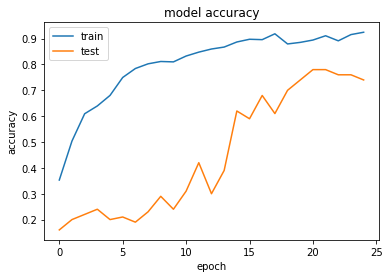

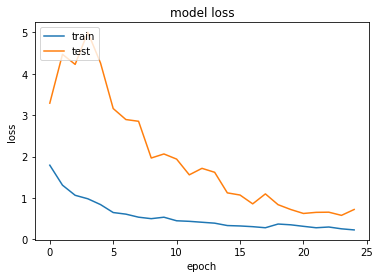

In [47]:
# Plotting the result of Model 8 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### The train accuracy is 92.46 % and best validation accuracy is 74 %

# Model 9.
## CNN-LSTM Model
## Increase Network Parameters

In [43]:
input_shape=(30,120,120,3)

CNNlstm_4 = Sequential()
CNNlstm_4.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_4.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_4.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_4.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())
CNNlstm_4.add(MaxPooling3D(pool_size=(2, 2, 2)))


CNNlstm_4.add(Flatten())
CNNlstm_4.add(Dense(128,activation='relu'))
CNNlstm_4.add(BatchNormalization())
CNNlstm_4.add(Dropout(0.25))

CNNlstm_4.add(Dense(128,activation='relu'))
CNNlstm_4.add(BatchNormalization())
CNNlstm_4.add(Dropout(0.25))


CNNlstm_4.add(Dense(5,activation='softmax'))

optimiser = tf.keras.optimizers.Adam()
CNNlstm_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (CNNlstm_4.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_29 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_17 (Conv3D)          (None, 30, 120, 120, 16)  6928      
                                                                 
 activation_17 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                     

In [44]:
print("Total Params in model:", CNNlstm_4.count_params())

Total Params in model: 1702645


In [45]:
batch_size = 20
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 25
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


In [46]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [48]:
history = CNNlstm_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_203/2772065864.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = CNNlstm_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.6526 - categorical_accuracy: 0.4178Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-11-0421_18_33.766009/model-00001-1.65260-0.41780-1.80539-0.26000.h5
34/34 [==============================] - 50s 1s/step - loss: 1.6526 - categorical_accuracy: 0.4178 - val_loss: 1.8054 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2464 - categorical_accuracy: 0.5400
Epoch 00002: saving model to model_init_2024-11-0421_18_33.766009/model-00002-1.24637-0.53997-2.49667-0.24000.h5
34/34 [==============================] - 47s 1s/step - loss: 1.2464 - categorical_accuracy: 0.5400 - val_loss: 2.4967 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0215 - categorical_accuracy: 0.6018
Ep

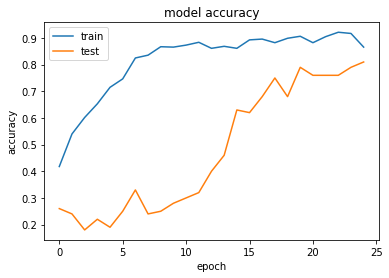

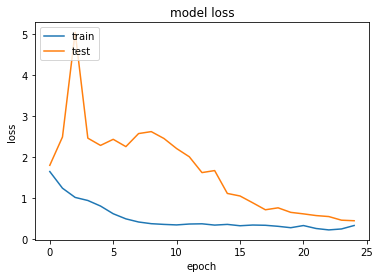

In [49]:
# Plotting the result of Model 9 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### Got best test accuracy of 86.58% and validation accuracy of 81% 

# Model 10.
## CNN LSTM with GRU

In [50]:
input_shape=(30,120,120,3)

GRU_lstm = Sequential()

GRU_lstm.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(input_shape)))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))


GRU_lstm.add(TimeDistributed(Flatten()))


GRU_lstm.add(GRU(128))
GRU_lstm.add(Dropout(0.25))

GRU_lstm.add(Dense(128,activation='relu'))
GRU_lstm.add(Dropout(0.25))

GRU_lstm.add(Dense(5, activation='softmax'))
optimiser = tf.keras.optimizers.Adam()
GRU_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (GRU_lstm.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 30, 60, 60, 32)  

In [51]:
print("Total Params in model:", GRU_lstm.count_params())

Total Params in model: 2573541


In [52]:
batch_size = 20
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [53]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [54]:
history = GRU_lstm.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_203/3182088282.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = GRU_lstm.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5041 - categorical_accuracy: 0.3529Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-11-0421_39_56.053200/model-00001-1.50414-0.35294-1.73302-0.24000.h5
34/34 [==============================] - 51s 1s/step - loss: 1.5041 - categorical_accuracy: 0.3529 - val_loss: 1.7330 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1813 - categorical_accuracy: 0.4932
Epoch 00002: saving model to model_init_2024-11-0421_39_56.053200/model-00002-1.18129-0.49321-1.98680-0.16000.h5
34/34 [==============================] - 48s 1s/step - loss: 1.1813 - categorical_accuracy: 0.4932 - val_loss: 1.9868 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0681 - categorical_accuracy: 0.5641
Ep

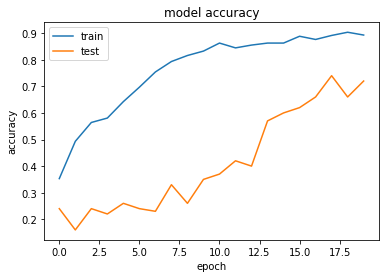

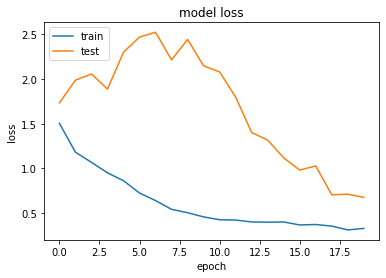

In [55]:
# Plotting the result of Model 10 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### We have got best test accuracy of 89.29 % and val accuracy of 72 %

# Model 11
## Model with Transfer Learning

In [57]:
# Importing the transfer learning model:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

In [ ]:
# MobileNet V2 model accepts one of the following formats: (96, 96), (128, 128), (160, 160),(192, 192), or (224, 224).
# Hence, we have got this warning for the input as we have not specified the input size while import.

In [58]:
# Building the model :

input_shape = (18,120,120,3)
        
mobileNetModel= Sequential()
mobileNetModel.add(TimeDistributed(mobilenet_transfer,input_shape=(input_shape)))


for layer in mobileNetModel.layers:
    layer.trainable = False


mobileNetModel.add(TimeDistributed(BatchNormalization()))
mobileNetModel.add(TimeDistributed(MaxPooling2D((2, 2))))
mobileNetModel.add(TimeDistributed(Flatten()))

mobileNetModel.add(LSTM(128))
mobileNetModel.add(Dropout(0.25))

mobileNetModel.add(Dense(128,activation='relu'))
mobileNetModel.add(Dropout(0.25))

mobileNetModel.add(Dense(5, activation='softmax'))


optimiser = tf.keras.optimizers.Adam()
mobileNetModel.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mobileNetModel.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_45 (TimeDi  (None, 18, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 18, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_47 (TimeDi  (None, 18, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_48 (TimeDi  (None, 18, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 128)              

In [59]:
print("Total Params in model:", mobileNetModel.count_params())

Total Params in model: 3840453


In [60]:
def generatorMobileNet(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,120,120,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [61]:
batch_size = 5
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [62]:
train_generator = generatorMobileNet(train_path, train_doc, batch_size)
val_generator = generatorMobileNet(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [63]:
history = mobileNetModel.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_203/3268031849.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = mobileNetModel.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.4340 - categorical_accuracy: 0.3816Source path =  /datasets/Project_data/val ; batch size = 5

Epoch 00001: saving model to model_init_2024-11-0421_57_47.183680/model-00001-1.43400-0.38160-1.03039-0.57000.h5
133/133 [==============================] - 39s 267ms/step - loss: 1.4340 - categorical_accuracy: 0.3816 - val_loss: 1.0304 - val_categorical_accuracy: 0.5700 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.8597 - categorical_accuracy: 0.6667
Epoch 00002: saving model to model_init_2024-11-0421_57_47.183680/model-00002-0.85970-0.66667-0.85979-0.67000.h5
133/133 [==============================] - 32s 240ms/step - loss: 0.8597 - categorical_accuracy: 0.6667 - val_loss: 0.8598 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.5210 - categorical_accur

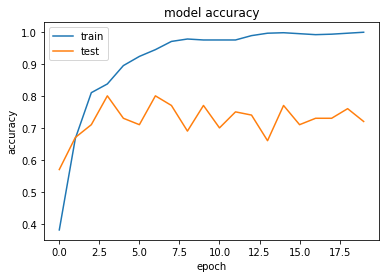

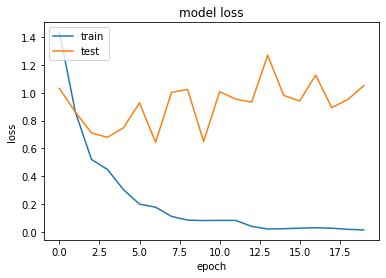

In [64]:
# Plotting the result of Model 11:

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### train accuracy of 99.85 % and val accuracy of 72 %.
### We are not training the mobilenet weights and we see validation accuracy is not good compare to train accuracy. Let's train them as well and observe if there is performance improvement.

# Model 12.
## Transfer Learning with GRU and training all weights

In [65]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

input_shape = (18,120,120,3)
        
mobileNetModelWeight = Sequential()
mobileNetModelWeight.add(TimeDistributed(mobilenet_transfer,input_shape=(input_shape)))


mobileNetModelWeight.add(TimeDistributed(BatchNormalization()))
mobileNetModelWeight.add(TimeDistributed(MaxPooling2D((2, 2))))
mobileNetModelWeight.add(TimeDistributed(Flatten()))

mobileNetModelWeight.add(GRU(128))
mobileNetModelWeight.add(Dropout(0.25))

mobileNetModelWeight.add(Dense(128,activation='relu'))
mobileNetModelWeight.add(Dropout(0.25))

mobileNetModelWeight.add(Dense(5, activation='softmax'))


optimiser = tf.keras.optimizers.Adam()
mobileNetModelWeight.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mobileNetModel.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_45 (TimeDi  (None, 18, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 18, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_47 (TimeDi  (None, 18, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_48 (TimeDi  (None, 18, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 128)              

In [66]:
print("Total Params in model:", mobileNetModel.count_params())

Total Params in model: 3840453


In [67]:
batch_size = 5
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [69]:
train_generator = generatorMobileNet(train_path, train_doc, batch_size)
val_generator = generatorMobileNet(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [70]:
history = mobileNetModelWeight.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_203/950158795.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = mobileNetModelWeight.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.4538 - categorical_accuracy: 0.3922Source path =  /datasets/Project_data/val ; batch size = 5

Epoch 00001: saving model to model_init_2024-11-0422_10_35.628466/model-00001-1.45379-0.39216-0.90233-0.66000.h5
133/133 [==============================] - 40s 270ms/step - loss: 1.4538 - categorical_accuracy: 0.3922 - val_loss: 0.9023 - val_categorical_accuracy: 0.6600 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.9056 - categorical_accuracy: 0.6606
Epoch 00002: saving model to model_init_2024-11-0422_10_35.628466/model-00002-0.90564-0.66063-0.83649-0.58000.h5
133/133 [==============================] - 34s 257ms/step - loss: 0.9056 - categorical_accuracy: 0.6606 - val_loss: 0.8365 - val_categorical_accuracy: 0.5800 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.7355 - categorical_accur

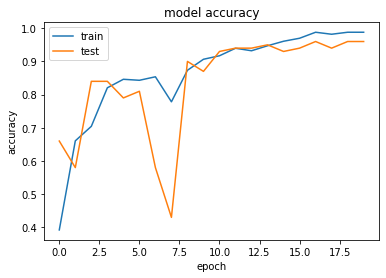

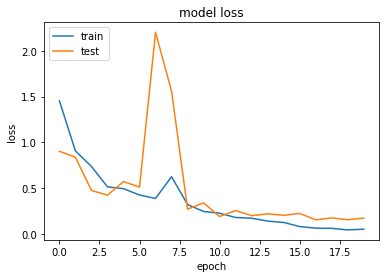

In [71]:
# Plotting the result of Model 12:

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Got the best test accuracy of 98.79 % and val accuracy of 96 %.

# Final Model Choosen :

## Transfer Learning with GRU and training all weights
### model name : model_init_2024-11-0422_10_35.628466/model-00020-0.04974-0.98793-0.17111-0.96000.h5
### This has completed training with good accuracy of 96 % over validation data.